# Group 4

### Problem Statement
Given this huge dataset of many various indicators, we would like to use machine learning, to be used on these indicators, that any regular adult can obtain by going through a health screening - to evaluate the risk any given individual has for heart disease.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pandas.api.types import is_string_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sb.set()

### Import the dataset

In [2]:
df = pd.read_csv('data/heart_2022_no_nans.csv')
# Preliminary check of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

From the above, we can see that there is a lot of categorical data. A few numerical data, like Height and Weight.

#### Data Cleaning
We would like to first check if the data is clean. We can first check if there exists any rows that has nulls in them.

In [3]:
print(df.isnull().values.any())

False


This tells us that there are no null values in any of the rows in the dataset. This is good. Next, we want to check if there are any odd values in the dataset. We can do this by looking and eyeballing.

In [4]:
for column in df:
    if is_string_dtype(df[column]):
        print(column, df[column].unique())

State ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
Sex ['Female' 'Male']
GeneralHealth ['Very good' 'Fair' 'Good' 'Excellent' 'Poor']
LastCheckupTime ['Within past year (anytime less than 12 months ago)'
 '5 or more years ago'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)']
PhysicalActivities ['Yes' 'No']
RemovedTeeth ['None of t

We want to check for categorical data, as we will not be able to look for any "odd" values for numerical values until we do some form of analysis. Most of the columns look fine, but there are some weird ones

- HadDiabetes (Yes, but only during pregnancy (female))
- HadDiabetes (No, pre-diabetes or borderline diabetes)
- ECigaretteUsage (Not at all (right now))
- CovidPos (Tested positive using home test without a health professional)

We want to check if these values are significant. If they are not a significant portion of the dataset, looking at these features specifically would not give us any new insights.

In [5]:
print("Had Diabetes : Yes, but only during pregnancy (female) : ", len(df.loc[df['HadDiabetes'] == 'Yes, but only during pregnancy (female)']) / len(df))
print("Had Diabetes : No, pre-diabetes or borderline diabetes : ", len(df.loc[df['HadDiabetes'] == 'No, pre-diabetes or borderline diabetes']) / len(df))
print("ECigaretteUsage : Not at all (right now) : ", len(df.loc[df['ECigaretteUsage'] == 'Not at all (right now)']) / len(df))
print("CovidPos : Tested positive using home test without a health professional: ", len(df.loc[df['CovidPos'] == 'Tested positive using home test without a health professional']) / len(df))

Had Diabetes : Yes, but only during pregnancy (female) :  0.008060254773963304
Had Diabetes : No, pre-diabetes or borderline diabetes :  0.021916739153409043
ECigaretteUsage : Not at all (right now) :  0.17592329141296306
CovidPos : Tested positive using home test without a health professional:  0.034110770581492714


We can see that both options for diabetes is definitely not significant. CovidPos is also not significant as well. The option for ECigarette Usage is very significant, almost 1/5 of the dataset. We will keep that one in.

In [6]:
df['HadDiabetes'] = df['HadDiabetes'].replace('Yes, but only during pregnancy (female)', 'Yes')
df['HadDiabetes'] = df['HadDiabetes'].replace('No, pre-diabetes or borderline diabetes', 'No')
df['CovidPos'] = df['CovidPos'].replace('Tested positive using home test without a health professional', 'Yes')

Check that the replacements are correct.

In [7]:
print(df['HadDiabetes'].unique())
print(df['CovidPos'].unique())

['No' 'Yes']
['No' 'Yes']


In [8]:
df.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


Since the response column is the 'HadHeartAttack' column, we want to check if there is sufficient in the dataset.

In [9]:
print(df['HadHeartAttack'].value_counts())

HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64


We notice that there is a significant class imbalance here. For every ~24 rows, there will be one Yes. If we used the dataset as it is, then it will be significantly skewed towards 'No'. There will be poor performance on the minority class ('Yes') in this case. 

To fix this, we would downsample the amount of 'No's to the amount of 'Yes's, so that there is an equal amount. We would prefer to not do the alternative, to upsample the 'Yes', should be done with caution as is the nature of the dataset here (medical).

We also observe that there is sufficient rows of 'Yes's that we can use, even after we downsample (13k rows each is sufficient). We will have ~26k rows to work with and we bleieve that will be enough for this.

In [10]:
counts = df['HadHeartAttack'].value_counts()
df = pd.concat([df[df['HadHeartAttack'] == value].sample(n=min(counts)) for value in counts.index])
print(df.head())

            State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
235682  Wisconsin  Female     Excellent                 0.0               0.0   
195512      Texas    Male     Excellent                 0.0               0.0   
231837  Wisconsin    Male     Very good                 0.0               0.0   
165136       Ohio    Male          Good                 2.0               0.0   
72087      Kansas    Male     Very good                 0.0               5.0   

                                          LastCheckupTime PhysicalActivities  \
235682  Within past year (anytime less than 12 months ...                Yes   
195512  Within past year (anytime less than 12 months ...                Yes   
231837  Within past year (anytime less than 12 months ...                Yes   
165136  Within past year (anytime less than 12 months ...                Yes   
72087   Within past year (anytime less than 12 months ...                Yes   

        SleepHours  RemovedTeeth

Note that `.sample` in pandas will randomly sample. So there will not be any bias in the sampling technique here.

### Exploratory Data Analysis
Given so many variables, the immediate task is to find out which variables are the most meaningful and contribute to the final response (HadHeartAttack). We can first do this by plotting a correlation heatmap, to sieve out what's useful and what's not.

In [11]:
numeric = df.select_dtypes(include = ['int', 'float'])
categorical = df.select_dtypes(include = ['object'])

numeric.set_index(df.index)
numeric['HadHeartAttack'] = df['HadHeartAttack']
numeric.head()

#print("Number of numeric columns: ", len(numeric.columns))
#print("Number of categorical columns: ", len(categorical.columns))

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack
235682,0.0,0.0,7.0,1.55,53.52,22.30,No
195512,0.0,0.0,6.0,1.70,97.52,33.67,No
231837,0.0,0.0,7.0,1.78,96.16,30.42,No
165136,2.0,0.0,7.0,1.83,104.33,31.19,No
72087,0.0,5.0,7.0,1.80,77.11,23.71,No


## Begin analysis on numeric data

We first plot out the basic data for the numeric columns of this dataset

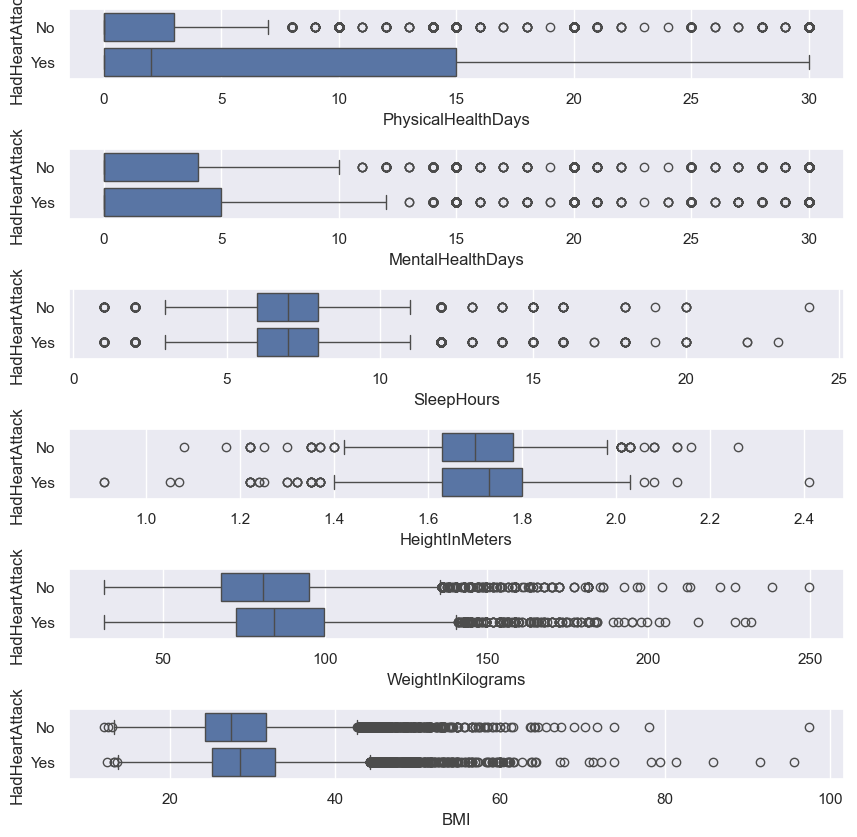

In [12]:
# Draw the distributions of all variables
f, axes = plt.subplots(6, 1, figsize=(10, 10), gridspec_kw={'hspace': 1})
f.subplots_adjust(hspace=0.3, wspace=0.3)

numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI' ]
for i, column in enumerate(numerical_columns):
    sb.boxplot(data = numeric, y='HadHeartAttack', x=column, orient = "h", ax = axes[i], showfliers = True)

## Analysis of numeric data
From the distrbution of numeric data in this dataset, there is no noticeable partitions to help classification with the exception of PhysicalHealthDays.

Moving forward, we can remove **BMI, WeightInKilograms, HeightInMeters, MentalHealthDays** from the classification tree

## Categorical data
We want to check see which categorical variables are best at predicting if a person has some form of heart disease.

In [13]:
# We don't want to include the HadHeartAttack column here as we want to compare against it.
categorical_columns = [col for col in df if is_string_dtype(df[col]) 
                       and col != 'HadHeartAttack'
                       and col != 'State'
                       and col != 'AgeCategory'
                       and col != 'RaceEthnicityCategory']
print(len(categorical_columns), categorical_columns)

30 ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


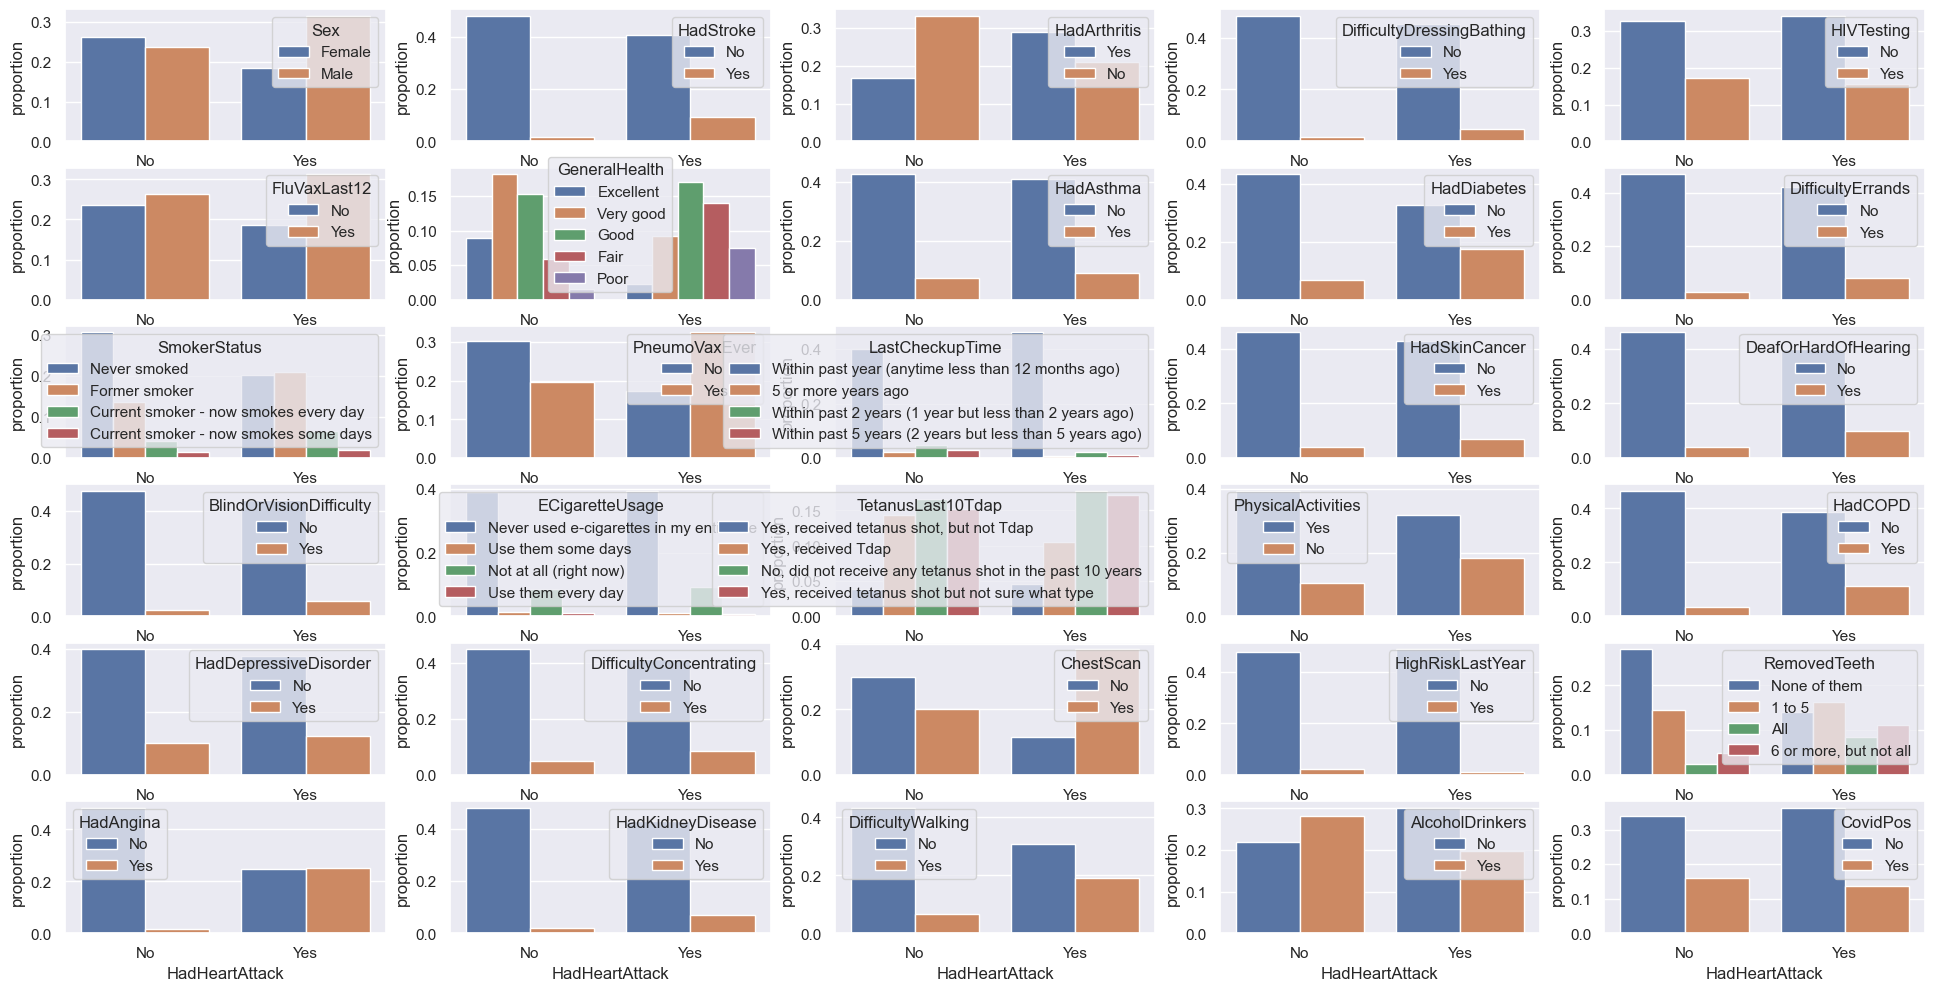

In [14]:
# 30 columns, so lets build 6x5 grid
f, axes = plt.subplots(6, 5, figsize=(24, 12))
for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    sb.countplot(pd.concat([df[col], df['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[r][c])

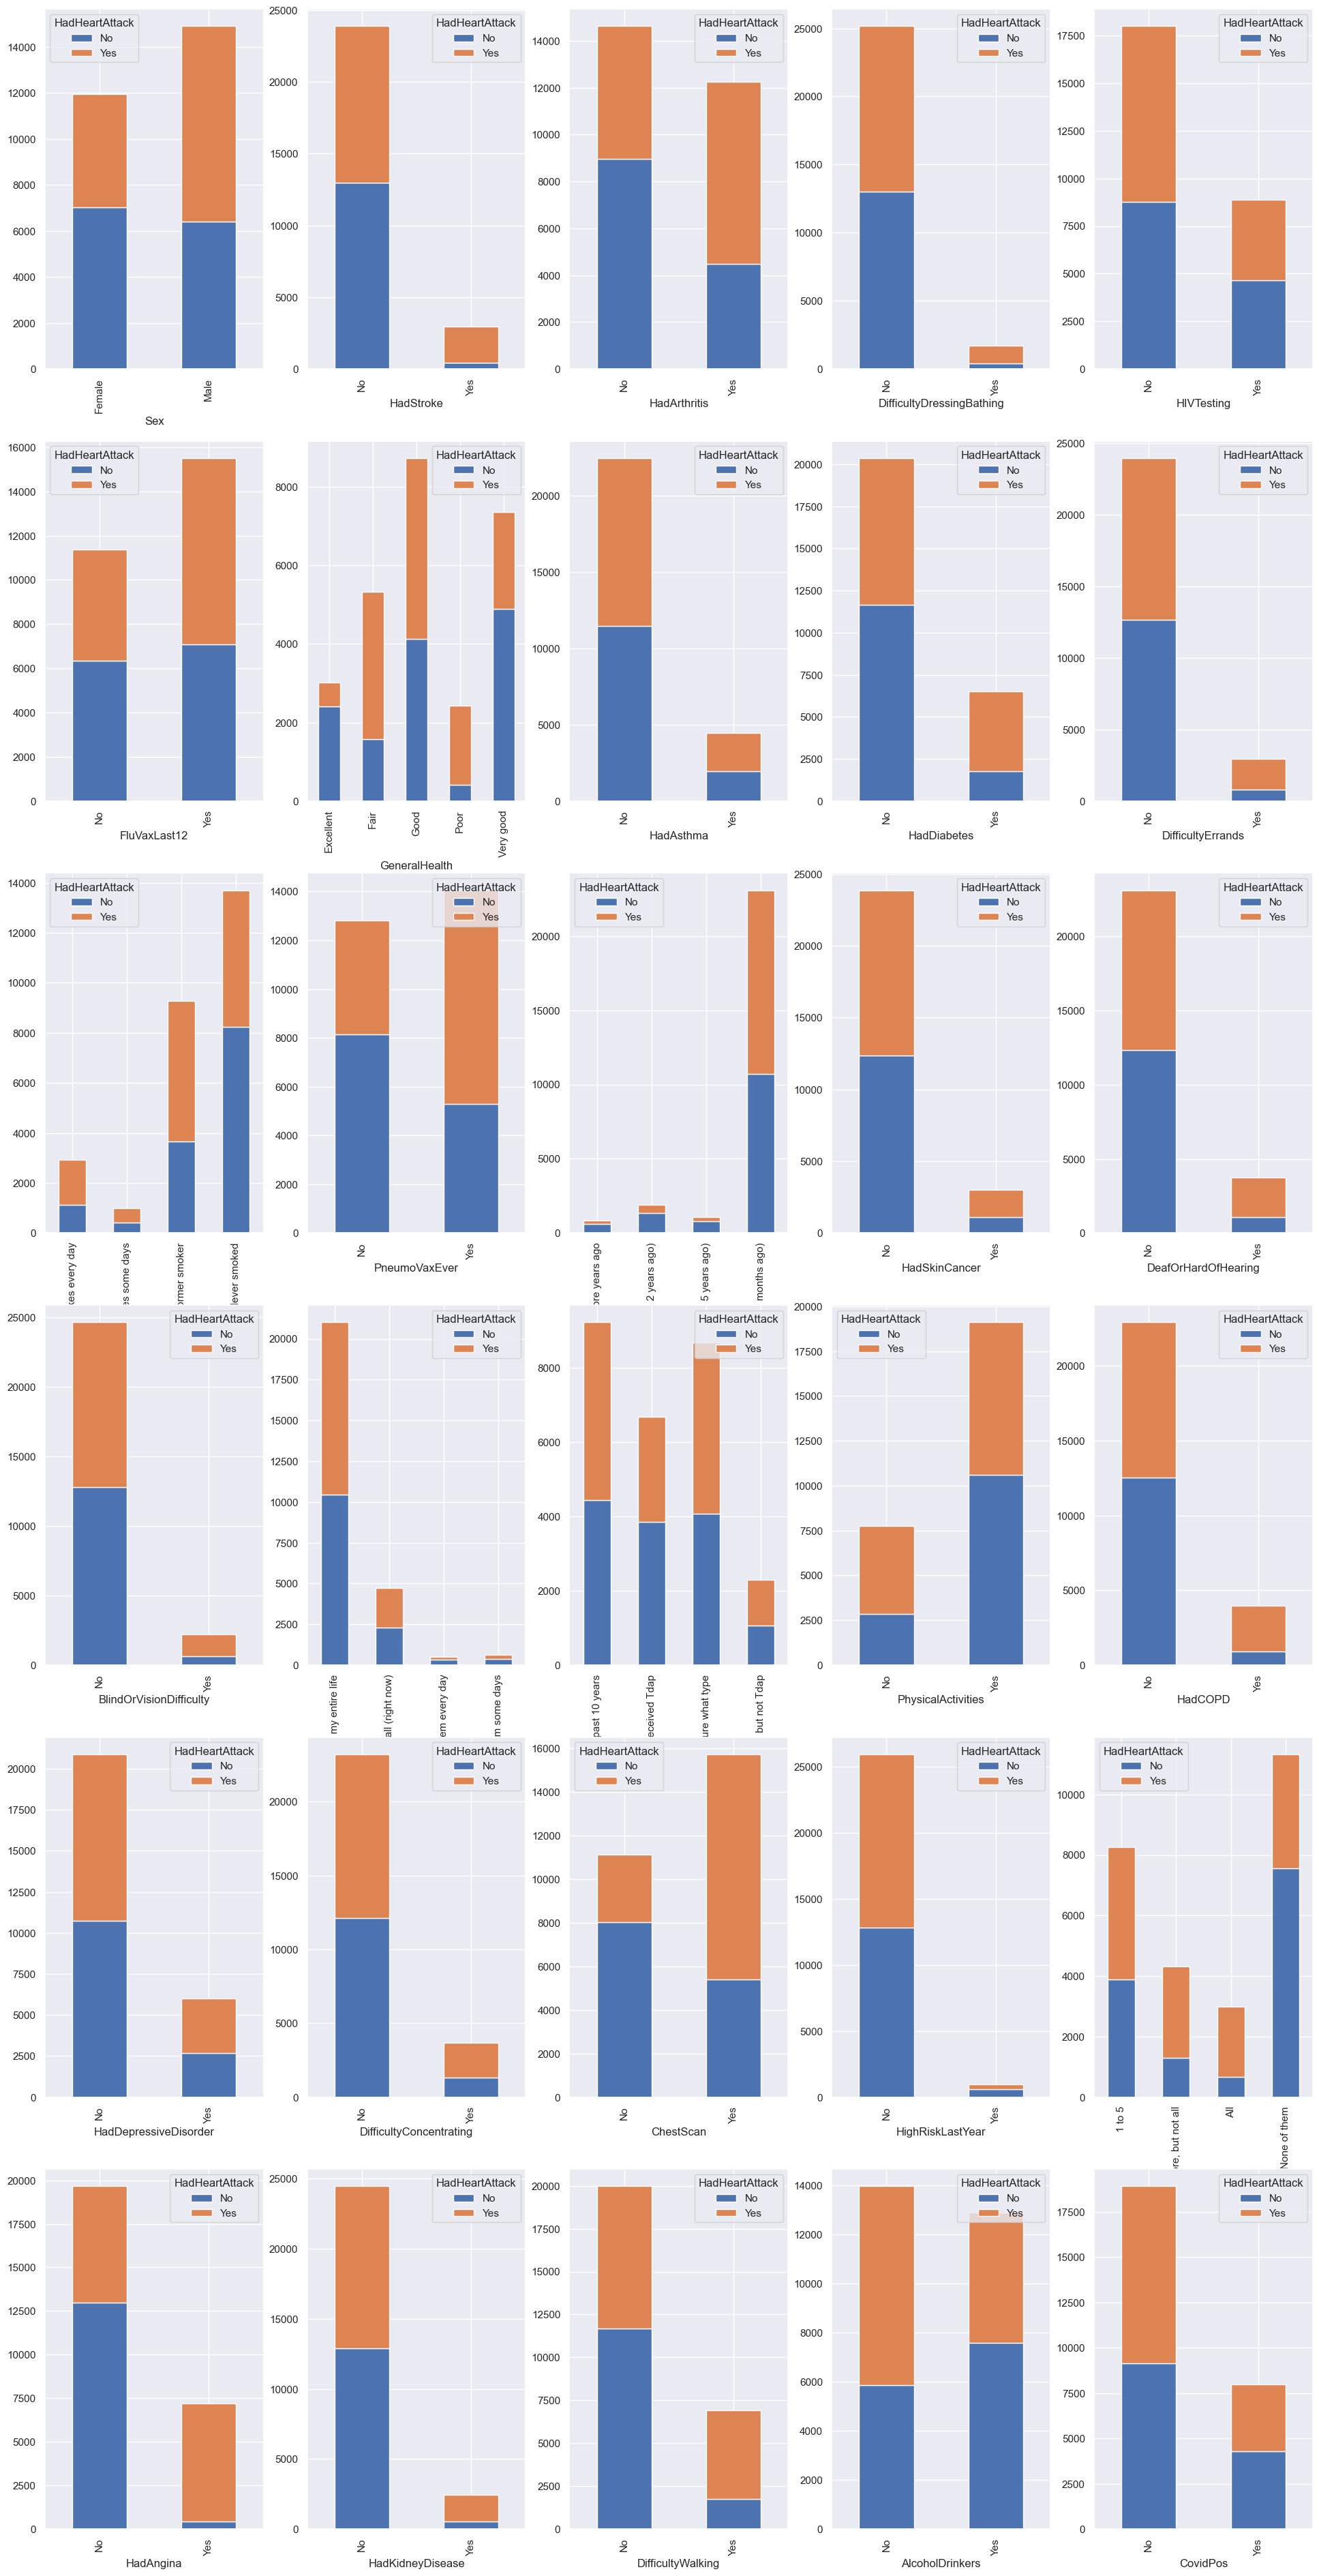

In [15]:
f, axes = plt.subplots(6, 5, figsize=(24, 48))
for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    
    result= df.groupby(col)['HadHeartAttack'].value_counts().unstack()
    result.plot(kind='bar', stacked=True, ax=axes[r][c])


We want to pick the columns that are useful

- We can see that HadStroke, DifficultyDressingBathing, DifficultyErands, HadAnigma

have a very strong correlation, so we will pick these columns and drop the rest.

## Analysis on numerical variables

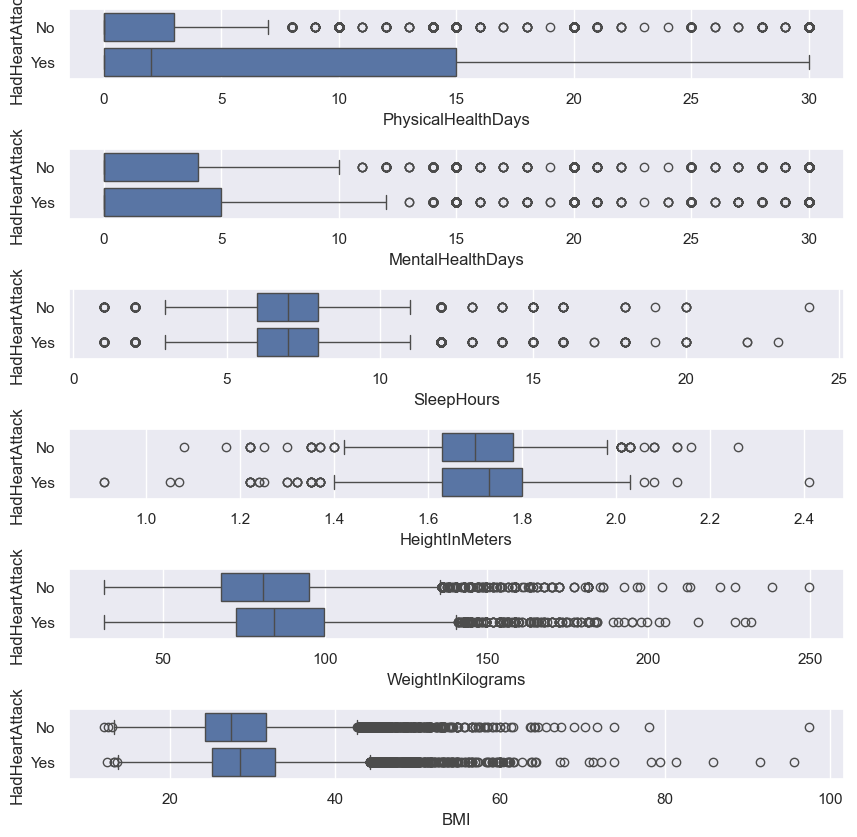

In [16]:
f, axes = plt.subplots(6, 1, figsize=(10, 10), gridspec_kw={'hspace': 1})
f.subplots_adjust(hspace=0.3, wspace=0.3)

numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI' ]
for i, column in enumerate(numerical_columns):
    sb.boxplot(data=df, y='HadHeartAttack', x=column, orient = "h", ax = axes[i], showfliers = True)

## Analysis of EDA on categorical variables
...(To be done)

In [17]:
# df = df.drop(df.columns.difference(numerical_columns + 
#                                    ['HadStroke', 'DifficultyDressingBathing', 'DifficultyErrands', 'HadAngina', 'HadHeartAttack']), axis=1)
df = df.drop(df.columns.difference(['PhysicalHealthDays'] + 
                                   ['DifficultyDressingBathing', 'DeafOrHardOfHearing', 'HadAngina', 'HadDepressiveDisorder', 'HadHeartAttack']), axis=1)

## Prepare the data for training

In [18]:
# category_columns = ['HadStroke', 'DifficultyDressingBathing', 'DifficultyErrands', 'HadAngina']
category_columns = ['DifficultyDressingBathing', 'DeafOrHardOfHearing', 'HadAngina', 'HadDepressiveDisorder']
df = pd.get_dummies(df, columns=category_columns, prefix_sep='')

# We don't want two separate yes/no columns for this
df['HadHeartAttack'] = df['HadHeartAttack'].replace({'Yes': 1, 'No': 0})

x = pd.DataFrame(df.drop(['HadHeartAttack'], axis=1))
y = pd.DataFrame(df['HadHeartAttack'])

x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2)

/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_37978/2461168927.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['HadHeartAttack'] = df['HadHeartAttack'].replace({'Yes': 1, 'No': 0})


## Modeling using Decision Tree
Firstly without dropping any columns and performing any sort of analysis to determine importance of features

[Text(0.5, 0.875, 'HadAnginaYes <= 0.5\ngini = 0.5\nsamples = 21496\nvalue = [10756.0, 10740.0]'),
 Text(0.25, 0.625, 'PhysicalHealthDays <= 5.5\ngini = 0.448\nsamples = 15721\nvalue = [10395, 5326]'),
 Text(0.125, 0.375, 'DeafOrHardOfHearingYes <= 0.5\ngini = 0.411\nsamples = 12214\nvalue = [8678, 3536]'),
 Text(0.0625, 0.125, 'gini = 0.391\nsamples = 11035\nvalue = [8089.0, 2946.0]'),
 Text(0.1875, 0.125, 'gini = 0.5\nsamples = 1179\nvalue = [589, 590]'),
 Text(0.375, 0.375, 'PhysicalHealthDays <= 14.5\ngini = 0.5\nsamples = 3507\nvalue = [1717, 1790]'),
 Text(0.3125, 0.125, 'gini = 0.49\nsamples = 1183\nvalue = [675, 508]'),
 Text(0.4375, 0.125, 'gini = 0.495\nsamples = 2324\nvalue = [1042, 1282]'),
 Text(0.75, 0.625, 'DifficultyDressingBathingNo <= 0.5\ngini = 0.117\nsamples = 5775\nvalue = [361.0, 5414.0]'),
 Text(0.625, 0.375, 'PhysicalHealthDays <= 3.5\ngini = 0.085\nsamples = 609\nvalue = [27, 582]'),
 Text(0.5625, 0.125, 'gini = 0.02\nsamples = 98\nvalue = [1.0, 97.0]'),
 Text

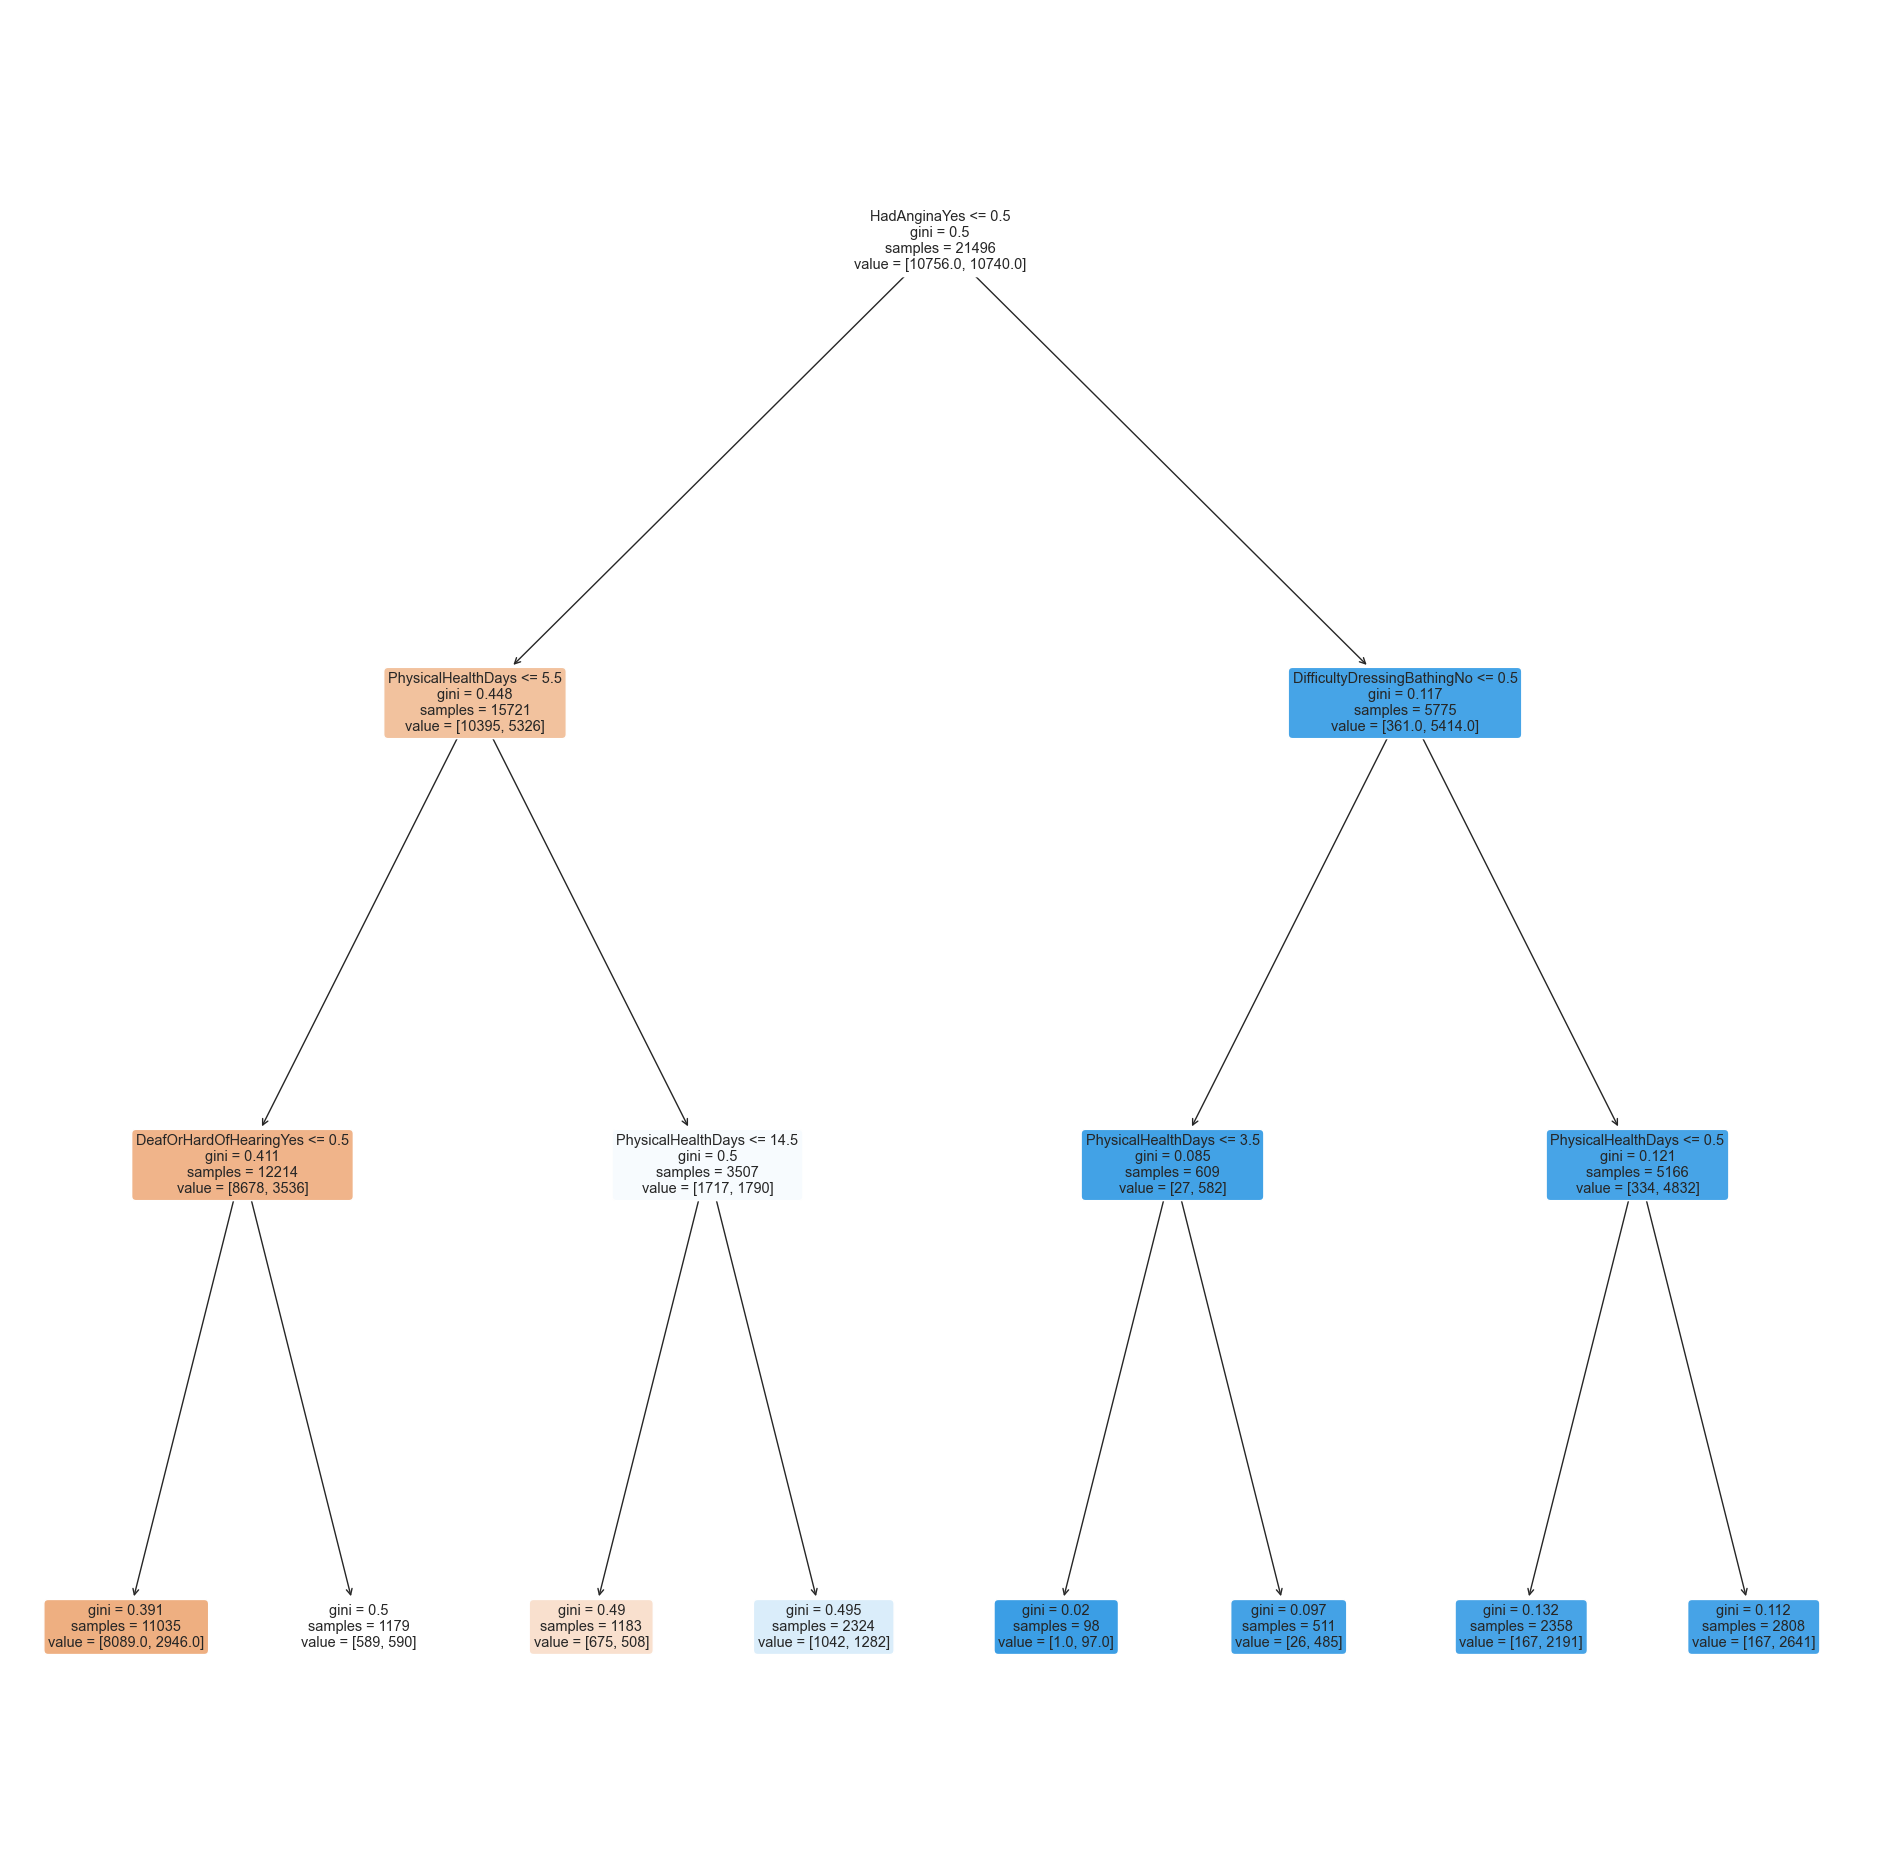

In [19]:
dectree = DecisionTreeClassifier(max_depth = 3)  # change max_depth to experiment
dectree.fit(x_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=x_train.columns.tolist())

Train Data
Accuracy  :	 0.7466505396352809

TPR Train :	 0.6783985102420856
TNR Train :	 0.814801041279286

FPR Train :	 0.185198958720714
FNR Train :	 0.32160148975791436


<Axes: >

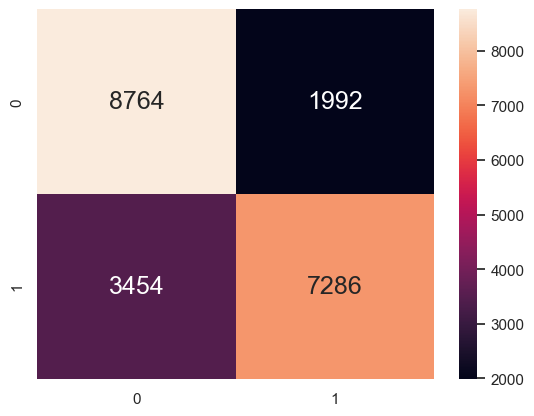

In [20]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(x_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(x_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Linear Regression Model

In [21]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Check the accuracy of this model

Train accuracy :  0.7471622627465575
Train MSE:  0.2528377372534425
Test accuracy :  0.7495347971715668
Test MSE:  0.2504652028284332
TPR Train :	 0.6032588454376164
TNR Train :	 0.8908516177017478
FPR Train :	 0.10914838229825213
FNR Train :	 0.3967411545623836


<Axes: >

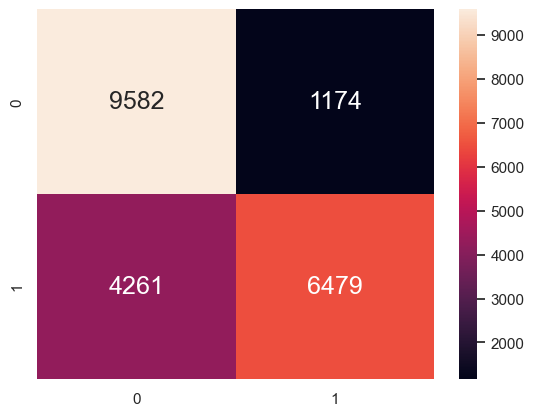

In [22]:
# Predict the Response corresponding to Predictors
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)

print("Train accuracy : ", logreg.score(x_train, y_train))
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))

print("Test accuracy : ", logreg.score(x_test, y_test))
print("Test MSE: ", mean_squared_error(y_test, y_test_pred))

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# SVM Model

In [23]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, y_train)
print(clf)

/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])


Train accuracy :  0.7500465202828434
Train MSE:  0.24995347971715667
Test accuracy :  0.7486043915147004
Test MSE:  0.25139560848529957
TPR Train :	 0.6143389199255122
TNR Train :	 0.8855522499070286
FPR Train :	 0.11444775009297137
FNR Train :	 0.3856610800744879


<Axes: >

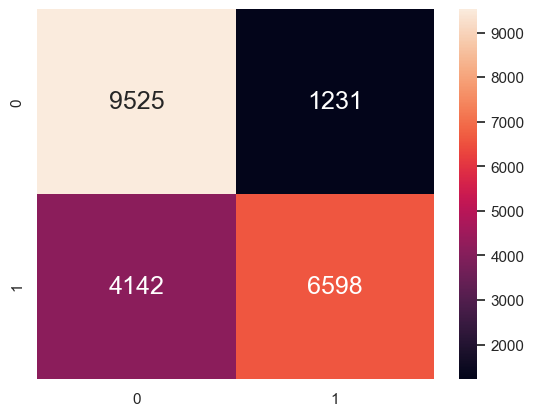

In [24]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

print("Train accuracy : ", clf.score(x_train, y_train))
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))

print("Test accuracy : ", clf.score(x_test, y_test))
print("Test MSE: ", mean_squared_error(y_test, y_test_pred))


# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Trying to feature select

In [25]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

In [26]:
# Reset the dataframe, would like to try to find best of all columns
df = pd.read_csv('data/heart_2022_no_nans.csv')
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [27]:
# category_columns = ['HadStroke', 'DifficultyDressingBathing', 'DifficultyErrands', 'HadAngina']
# df = pd.get_dummies(df, columns=category_columns, prefix_sep='')

# We don't want two separate yes/no columns for this
df['HadHeartAttack'] = df['HadHeartAttack'].replace({'Yes': 1, 'No': 0})
df_onehot = pd.get_dummies(df)

x = pd.DataFrame(df_onehot.drop(['HadHeartAttack'], axis=1))
y = pd.DataFrame(df_onehot['HadHeartAttack'])

print(x)
print(y)

/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_37978/3293010257.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['HadHeartAttack'] = df['HadHeartAttack'].replace({'Yes': 1, 'No': 0})


        PhysicalHealthDays  MentalHealthDays  SleepHours  HeightInMeters  \
0                      4.0               0.0         9.0            1.60   
1                      0.0               0.0         6.0            1.78   
2                      0.0               0.0         8.0            1.85   
3                      5.0               0.0         9.0            1.70   
4                      3.0              15.0         5.0            1.55   
...                    ...               ...         ...             ...   
246017                 0.0               0.0         6.0            1.78   
246018                 0.0               7.0         7.0            1.93   
246019                 0.0              15.0         7.0            1.68   
246020                 2.0               2.0         7.0            1.70   
246021                 0.0               0.0         5.0            1.83   

        WeightInKilograms    BMI  State_Alabama  State_Alaska  State_Arizona  \
0      

In [28]:
selector = SelectKBest(mutual_info_classif, k=15)
x_new = selector.fit_transform(x, y)

/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
mask = selector.get_support()
features = df_onehot.columns
for b, val in zip(mask, features):
    if b:
        print(val)

LastCheckupTime_Within past 5 years (2 years but less than 5 years ago)
PhysicalActivities_No
RemovedTeeth_All
RemovedTeeth_None of them
HadAngina_Yes
HadDepressiveDisorder_Yes
HadKidneyDisease_Yes
HadArthritis_Yes
DeafOrHardOfHearing_Yes
DifficultyConcentrating_Yes
DifficultyWalking_Yes
DifficultyDressingBathing_Yes
ECigaretteUsage_Use them some days
FluVaxLast12_Yes
TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap
